<a href="https://colab.research.google.com/github/Neyaz786/Online-Payment-Fraud-Detection/blob/main/Online_Payment_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np



In [10]:
!pip install --upgrade kagglehub pandas

import kagglehub
import pandas as pd
import os

# Download dataset locally (returns the folder path)
dataset_path = kagglehub.dataset_download("rupakroy/online-payments-fraud-detection-dataset")
print("Dataset downloaded to:", dataset_path)

# Check the files inside
print(os.listdir(dataset_path))


Dataset downloaded to: /kaggle/input/online-payments-fraud-detection-dataset
['PS_20174392719_1491204439457_log.csv']


In [18]:
# Load the CSV (replace with actual file name from the list above)
csv_file = os.path.join(dataset_path, "PS_20174392719_1491204439457_log.csv")
df = pd.read_csv(csv_file)

df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [19]:
print(df.isnull().sum())

# Exploring transaction type
print(df.type.value_counts())


step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64
type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64


In [6]:
type = df["type"].value_counts()
transactions = type.index
quantity = type.values

import plotly.express as px
figure = px.pie(df,
             values=quantity,
             names=transactions, hole=0.5,
             title="Distribution of Transaction Type")
figure.show()

In [20]:
# Drop non-numeric columns before calculating correlation
df = df.drop(['nameOrig', 'nameDest'], axis=1)

# Convert 'type' column to numeric using the provided mapping
df["type"] = df["type"].map({"CASH_OUT": 1, "PAYMENT": 2,
                                 "CASH_IN": 3, "TRANSFER": 4,
                                 "DEBIT": 5})

# Checking correlation
correlation = df.corr(numeric_only=True) # Calculate correlation only for numeric columns
print(correlation["isFraud"].sort_values(ascending=False))

# Keep the mapping for 'isFraud' column for later use
df["isFraud"] = df["isFraud"].map({0: "No Fraud", 1: "Fraud"})

print(df.head())

isFraud           1.000000
amount            0.076688
isFlaggedFraud    0.044109
step              0.031578
type              0.016171
oldbalanceOrg     0.010154
newbalanceDest    0.000535
oldbalanceDest   -0.005885
newbalanceOrig   -0.008148
Name: isFraud, dtype: float64
   step  type    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1     2   9839.64       170136.0       160296.36             0.0   
1     1     2   1864.28        21249.0        19384.72             0.0   
2     1     4    181.00          181.0            0.00             0.0   
3     1     1    181.00          181.0            0.00         21182.0   
4     1     2  11668.14        41554.0        29885.86             0.0   

   newbalanceDest   isFraud  isFlaggedFraud  
0             0.0  No Fraud               0  
1             0.0  No Fraud               0  
2             0.0     Fraud               0  
3             0.0     Fraud               0  
4             0.0  No Fraud               0  


In [21]:
# splitting the data
from sklearn.model_selection import train_test_split
x = np.array(df[["type", "amount", "oldbalanceOrg", "newbalanceOrig"]])
y = np.array(df[["isFraud"]])


In [22]:
# training a machine learning model
from sklearn.tree import DecisionTreeClassifier
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.10, random_state=42)
model = DecisionTreeClassifier()
model.fit(xtrain, ytrain)
print(model.score(xtest, ytest))


0.9997406728674666


Accuracy: 0.9997406728674666


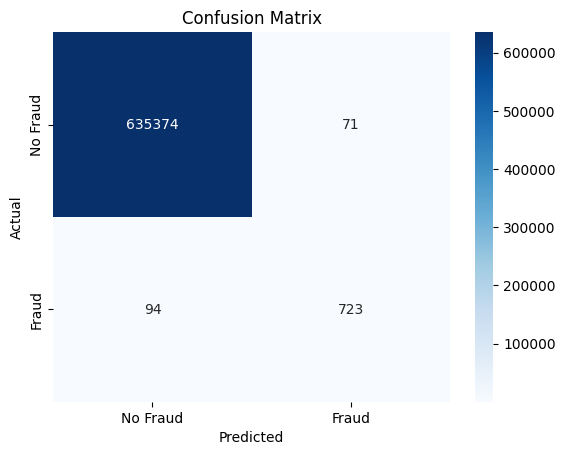

In [24]:
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions on the test set
y_pred = model.predict(xtest)

# Accuracy
acc = accuracy_score(ytest, y_pred)
print("Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(ytest, y_pred, labels=["No Fraud", "Fraud"])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Fraud", "Fraud"],
            yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


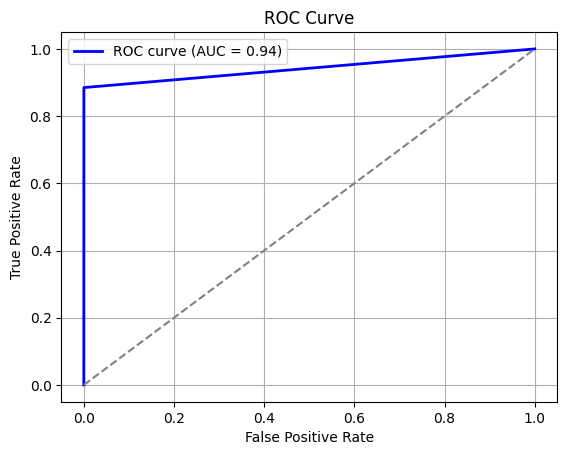

In [25]:
from sklearn.metrics import roc_curve, auc

# Convert labels to binary (Fraud=1, No Fraud=0) for ROC
ytest_bin = np.where(ytest == "Fraud", 1, 0)
y_pred_bin = np.where(y_pred == "Fraud", 1, 0)

fpr, tpr, _ = roc_curve(ytest_bin, y_pred_bin)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
# prediction
# features = [type, amount, oldbalanceOrg, newbalanceOrig]
features = np.array([[4, 9000.60, 9000.60, 0.0]])
print(model.predict(features))


['Fraud']
